<a href="https://colab.research.google.com/github/leeliangchao/-spatiotemporal-pedict/blob/main/24%E7%82%B9%E9%A2%84%E6%B5%8B%E4%B8%80%E5%A4%A9/7%E5%A4%A9%E9%A2%84%E6%B5%8B1%E5%A4%A9.ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

In [42]:
# !pip install mlxtend==0.18
# from mlxtend.plotting import heatmap


## 范围选择

In [43]:
Longitude_Index = 54    #经度索引
Longitude_End = 62 +1   #经度索引

Latitude_Index = 17  # 纬度索引
Latitude_End = 31 +1 # 纬度索引

In [44]:
Sample = np.load('/content/drive/MyDrive/TEC/日本3台站/CODE/TEC.npy')

In [45]:
Sample.shape

(71, 73, 25, 366, 1)

In [46]:
Target_region = Sample[Latitude_Index:Latitude_End, Longitude_Index:Longitude_End,:,:,:]

In [47]:
# fig, ax = plt.subplots(figsize=(4, 4), dpi=100)
# line=ax.matshow(Target_region[:,:,-2,0,0], cmap = plt.cm.winter)
# plt.show()
# type(line)

In [48]:
# from matplotlib import animation

In [49]:
# def animate(i):
#   line.set_data(Target_region[:,:,i,0,0])
#   return line,
# def init():
#   line.set_data(Target_region[:,:,0,0,0])
#   return line,
# ani = animation.FuncAnimation(fig=fig, func=animate,frames=25,init_func=init,interval=200,blit=False)
# ani.save('ani.gif', writer='pillow')
# plt.show()

### 样本制作

In [50]:
###################绘图###################
import matplotlib.pyplot as plt
###################标准化###################
# from sklearn.preprocessing import MinMaxScaler

In [51]:
Target_region.shape

(15, 9, 25, 366, 1)

In [52]:
data = np.swapaxes(Target_region, 0,2)
data = np.swapaxes(data, 1,3)
data = np.swapaxes(data, 0,1)

In [53]:
data.shape

(366, 25, 15, 9, 1)

In [54]:
data = np.delete(data,[-1], axis=0);data.shape

(365, 25, 15, 9, 1)

In [55]:
new_data = np.zeros((data.shape[0],24,data.shape[2],data.shape[3],data.shape[4],))
for i in range(data.shape[0]):
    k = 0
    for j in range(0,24,1):
        new_data[i,k,:,:,:] = data[i,j,:,:,:]
        k +=1

In [56]:
new_data.shape

(365, 24, 15, 9, 1)

In [57]:
data = new_data.reshape(-1,15,9,1)

In [58]:
data.shape

(8760, 15, 9, 1)

In [59]:
# data = data[::2]

In [60]:
data.shape

(8760, 15, 9, 1)

In [61]:
# 数据集划分
def create_dataset(data, look_back=24*7, forward=24):
  x = []
  y = []
  for i in range(0,data.shape[0]-(look_back+forward)+1,forward):
    x.append(data[i:i+look_back,:,:,:])
    y.append(data[i+look_back:i+look_back+forward,:,:,:])
  return (np.array(x), np.array(y))


In [62]:
a,b = create_dataset(data)

In [63]:
a.shape,b.shape

((358, 168, 15, 9, 1), (358, 24, 15, 9, 1))

In [64]:
# len(df)为df多少行
pot = round(0.8 * a.shape[0])
pot

286

In [65]:
x_train, y_train = a[:pot],b[:pot]
x_test, y_test = a[pot:],b[pot:]
# y_train = np.expand_dims(y_train, 1)
# y_test = np.expand_dims(y_test, 1)

In [66]:
x_train.shape, x_test.shape,y_test.shape

((286, 168, 15, 9, 1), (72, 168, 15, 9, 1), (72, 24, 15, 9, 1))

### LearningRateScheduler调整学习率

In [67]:
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [74]:
K.set_floatx('float32')

In [75]:
def scheduler(epoch):
    if epoch % 30 ==0 and epoch != 0 :
        lr = K.get_value(tcn.optimizer.lr)
        if lr > 1e-5:
            K.set_value(tcn.optimizer.lr, lr *0.5)
            print('lr changed to {}'.format(lr * 0.5))
    return K.get_value(tcn.optimizer.lr)

In [76]:
reduce_lr = LearningRateScheduler(scheduler)

In [77]:
import tensorflow as tf
from tensorflow.keras.layers import ConvLSTM2D,Conv2D,Conv3D,BatchNormalization,Flatten,RepeatVector,Reshape
from tensorflow.keras import Input, Model, Sequential
from sklearn.metrics import mean_squared_error

In [78]:
# 自定义损失函数
def my_metric_fn(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
# Loss function
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0, filter_size=3))

In [79]:
#输入维数
tcn = Sequential()
input_layer =Input(shape=(x_train.shape[1:]))
tcn.add(input_layer)
tcn.add(
    ConvLSTM2D(
        filters=64,
        kernel_size=(3,3),
        padding='same',
        return_sequences=True
    )
)
tcn.add(BatchNormalization())
# tcn.add(LayerNormalization())
tcn.add(
    ConvLSTM2D(
        filters=64,
        kernel_size=(3,3),
        padding='same',
        return_sequences=True
    )
)
tcn.add(BatchNormalization())
# tcn.add(LayerNormalization())
tcn.add(
    ConvLSTM2D(
        filters=64,
        kernel_size=(3,3),
        padding='same',
        return_sequences=True
    )
)
tcn.add(BatchNormalization())
# tcn.add(LayerNormalization())
tcn.add(
    ConvLSTM2D(
        filters=64,
        kernel_size=(3,3),
        padding='same',
        return_sequences=False
    )
)
tcn.add(BatchNormalization())
# ###############################
tcn.add(Flatten())
tcn.add(RepeatVector(24))
tcn.add(Reshape((24,15,9,64)))
tcn.add(
    ConvLSTM2D(
        filters=64,
        kernel_size=(3,3),
        padding='same',
        return_sequences=True
    )
)
tcn.add(BatchNormalization())
tcn.add(
    ConvLSTM2D(
        filters=64,
        kernel_size=(3,3),
        padding='same',
        return_sequences=True
    )
)
tcn.add(BatchNormalization())
# tcn.add(LayerNormalization())
tcn.add(Conv3D(filters=1, kernel_size=(3,3,3),activation="linear", padding="same"))
tcn.compile(tf.keras.optimizers.Adam(learning_rate=0.01), loss=root_mean_squared_error)# RMSE
tcn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_14 (ConvLSTM2D)  (None, 168, 15, 9, 64)   150016    
                                                                 
 batch_normalization_12 (Bat  (None, 168, 15, 9, 64)   256       
 chNormalization)                                                
                                                                 
 conv_lstm2d_15 (ConvLSTM2D)  (None, 168, 15, 9, 64)   295168    
                                                                 
 batch_normalization_13 (Bat  (None, 168, 15, 9, 64)   256       
 chNormalization)                                                
                                                                 
 conv_lstm2d_16 (ConvLSTM2D)  (None, 168, 15, 9, 64)   295168    
                                                                 
 batch_normalization_14 (Bat  (None, 168, 15, 9, 64)  

In [80]:
!nvidia-smi

Tue Nov 15 01:02:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    31W /  70W |  14592MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [85]:
history=tcn.fit(x_train,y_train, 
        epochs=240, batch_size=32,validation_data=[x_test, y_test], callbacks=[reduce_lr])


Epoch 1/240
9/9 [==============================] - 44s 5s/step - loss: 9.9252 - val_loss: 7.6392 - lr: 0.0100
Epoch 2/240
9/9 [==============================] - 43s 5s/step - loss: 5.6545 - val_loss: 5.5016 - lr: 0.0100
Epoch 3/240
9/9 [==============================] - 41s 5s/step - loss: 4.2539 - val_loss: 5.6834 - lr: 0.0100
Epoch 4/240
9/9 [==============================] - 41s 5s/step - loss: 3.0254 - val_loss: 5.4931 - lr: 0.0100
Epoch 5/240
9/9 [==============================] - 42s 5s/step - loss: 2.7251 - val_loss: 5.3183 - lr: 0.0100
Epoch 6/240
9/9 [==============================] - 42s 5s/step - loss: 2.5669 - val_loss: 4.6630 - lr: 0.0100
Epoch 7/240
9/9 [==============================] - 43s 5s/step - loss: 2.4277 - val_loss: 4.5165 - lr: 0.0100
Epoch 8/240
9/9 [==============================] - 41s 5s/step - loss: 2.3172 - val_loss: 4.5948 - lr: 0.0100
Epoch 9/240
9/9 [==============================] - 40s 5s/step - loss: 2.2125 - val_loss: 4.6186 - lr: 0.0100
Epoch 10/2

In [ ]:
# history.history.keys() #查看history中存储了哪些参数

In [ ]:
# plt.plot(history.epoch,history.history.get('my_metric_fn')[:]) #画出随着epoch增大loss的变化图
#plt.plot(history.epoch,history.history.get('acc'))#画出随着epoch增大准确率的变化图

In [ ]:
# plt.plot(history.epoch, history.history.get('lr'))

In [ ]:
# from tensorflow.keras.models import load_model
# tcn = load_model('/content/7d2d.h5',custom_objects={'root_mean_squared_error':root_mean_squared_error})

In [86]:
tcn.evaluate(x_test, y_test)

3/3 [==============================] - 2s 621ms/step - loss: 1.7387


1.7387089729309082

In [87]:
predict = tcn.predict(x_test)

3/3 [==============================] - 3s 623ms/step


In [88]:
predict.shape

(72, 24, 15, 9, 1)

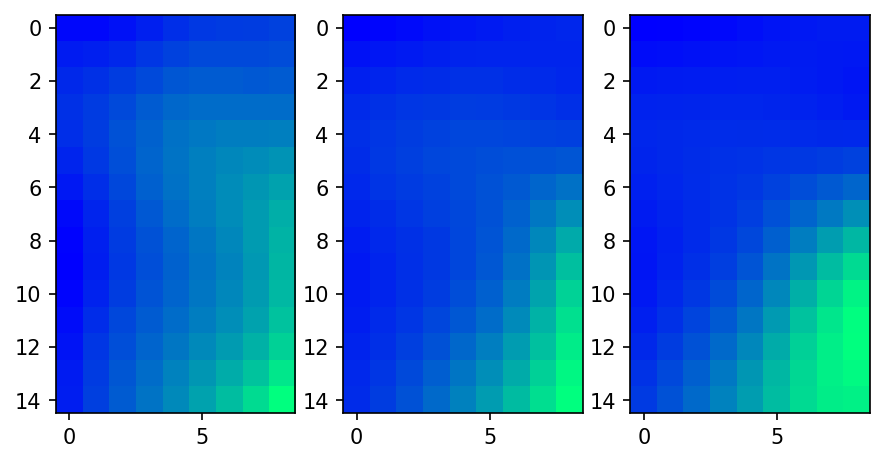

In [89]:
#@title
test_day = 1

fig, ax = plt.subplots(1,3,figsize=(7,7),dpi=150)

im1 = ax[0].imshow(y_test[test_day,0,:,:,0], cmap = plt.cm.winter)
im1 = ax[1].imshow(y_test[test_day,1,:,:,0], cmap = plt.cm.winter)
im1 = ax[2].imshow(y_test[test_day,2,:,:,0], cmap = plt.cm.winter)

# im1 = ax[1][0].imshow(y_test[test_day,3,:,:,0], cmap = plt.cm.winter)
# im1 = ax[1][1].imshow(y_test[test_day,4,:,:,0], cmap = plt.cm.winter)
# im1 = ax[1][2].imshow(y_test[test_day,5,:,:,0], cmap = plt.cm.winter)
# im1 = ax[2][0].imshow(y_test[test_day,6,:,:,0], cmap = plt.cm.winter)
# im1 = ax[2][1].imshow(y_test[test_day,7,:,:,0], cmap = plt.cm.winter)
# im1 = ax[2][2].imshow(y_test[test_day,8,:,:,0], cmap = plt.cm.winter)
# im1 = ax[3][0].imshow(y_test[test_day,9,:,:,0], cmap = plt.cm.winter)
# im1 = ax[3][1].imshow(y_test[test_day,10,:,:,0], cmap = plt.cm.winter)
# im1 = ax[3][2].imshow(y_test[test_day,11,:,:,0], cmap = plt.cm.winter)

# plt.colorbar(im1)

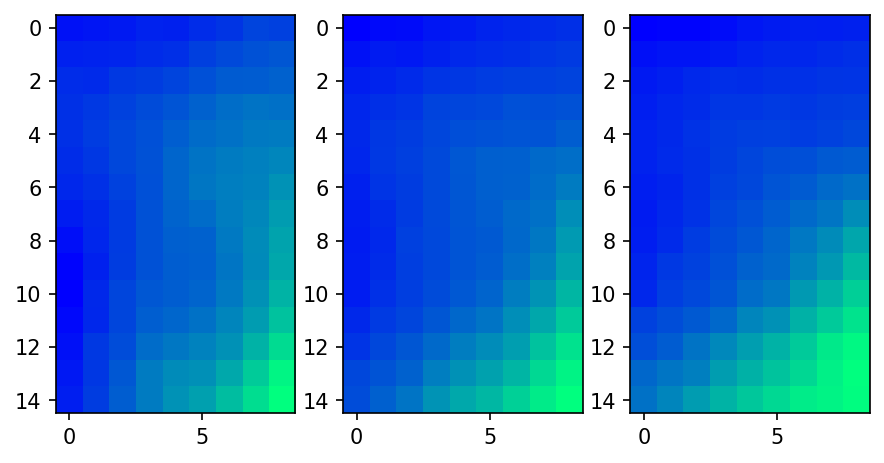

In [90]:
#@title
fig, ax = plt.subplots(1,3,figsize=(7,7),dpi=150)

im1 = ax[0].imshow(predict[test_day,0,:,:,0], cmap = plt.cm.winter)
im1 = ax[1].imshow(predict[test_day,1,:,:,0], cmap = plt.cm.winter)
im1 = ax[2].imshow(predict[test_day,2,:,:,0], cmap = plt.cm.winter)

# im1 = ax[1][0].imshow(predict[test_day,3,:,:,0], cmap = plt.cm.winter)
# im1 = ax[1][1].imshow(predict[test_day,4,:,:,0], cmap = plt.cm.winter)
# im1 = ax[1][2].imshow(predict[test_day,5,:,:,0], cmap = plt.cm.winter)
# im1 = ax[2][0].imshow(predict[test_day,6,:,:,0], cmap = plt.cm.winter)
# im1 = ax[2][1].imshow(predict[test_day,7,:,:,0], cmap = plt.cm.winter)
# im1 = ax[2][2].imshow(predict[test_day,8,:,:,0], cmap = plt.cm.winter)
# im1 = ax[3][0].imshow(predict[test_day,9,:,:,0], cmap = plt.cm.winter)
# im1 = ax[3][1].imshow(predict[test_day,10,:,:,0], cmap = plt.cm.winter)
# im1 = ax[3][2].imshow(predict[test_day,11,:,:,0], cmap = plt.cm.winter)

In [91]:
tcn.save('7d1d_j.h5')

### RMSE计算

In [92]:
from sklearn.metrics import mean_squared_error

In [108]:
P = predict
P = P.reshape(-1,1)
P.shape

(233280, 1)

In [109]:
R = y_test
R = R.reshape(-1,1)
R.shape

(233280, 1)

In [95]:
mean_squared_error(R, P, squared=False)

1.755975463326693

### 计算$R^{2}$

In [98]:
from sklearn.metrics import r2_score

In [99]:
r2 = round(r2_score(P, R),4)
r2

0.9178

### 算相对误差直方图

Text(0.5, 0, 'Residual(TECU)')

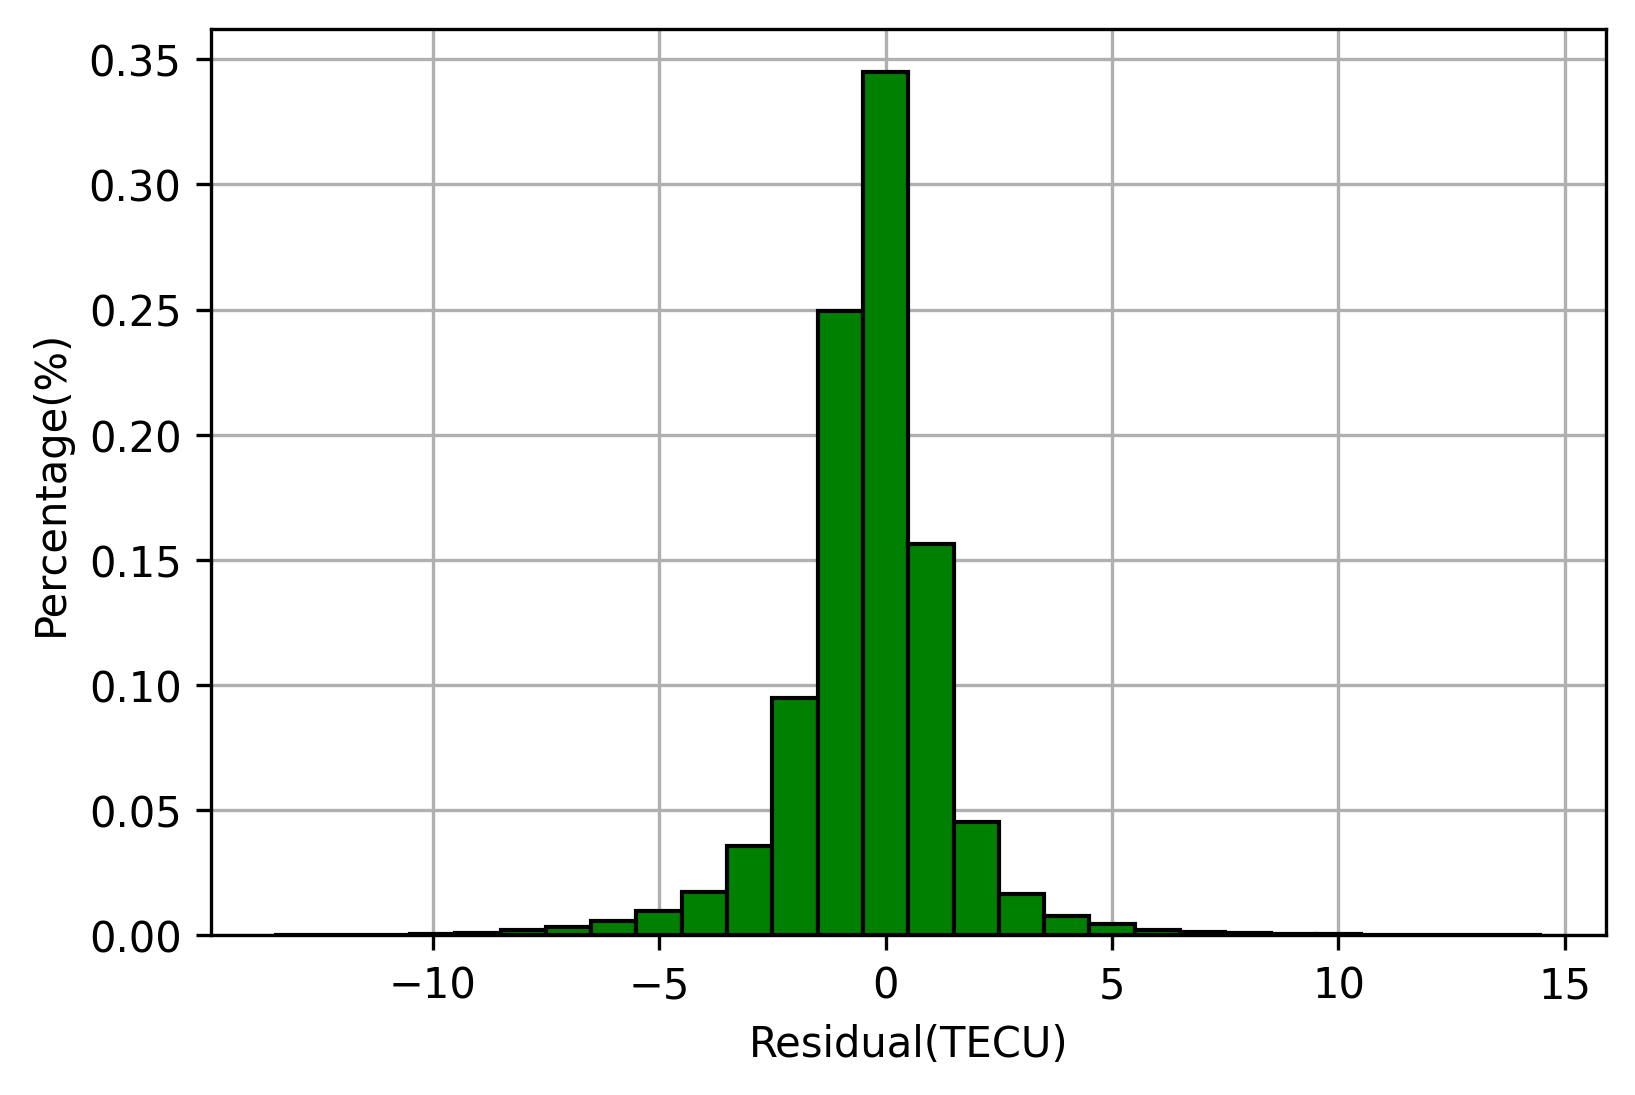

In [100]:
PD = (R-P)
fig, ax = plt.subplots(dpi=300)
ax.grid(True, zorder=1)
distance = .5
# groups_num = int((np.ceil(max(PD))-np.floor(min(PD)))//distance)
groups_num = np.arange(np.floor(min(PD))-0.5,np.ceil(max(PD)), 1)

ax.hist(PD, bins=groups_num, density=True, edgecolor='k',color='g',zorder=2)
# ax.set_xticks(np.arange(-8,9,2))
# ax.set_xlim([-8,8])
ax.set_ylabel("Percentage(%)")
ax.set_xlabel("Residual(TECU)")

### 计算预测显示的散点图

(0.4, 34.0321145772934)

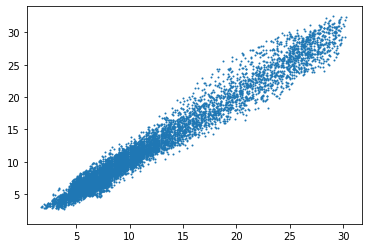

In [107]:
plt.scatter(R,P, s=1)
plt.xlim((0.40))
plt.ylim((0.40))

In [102]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(R, P)

reg.coef_, reg.intercept_

(array([[0.9877932]]), array([0.47146713]))

In [103]:
line_x = np.linspace(0, 30, 2)
y = reg.coef_[0][0] * line_x + reg.intercept_[0]
y

array([ 0.47146713, 30.10526309])

In [104]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde

In [105]:
P.shape

(233280, 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  


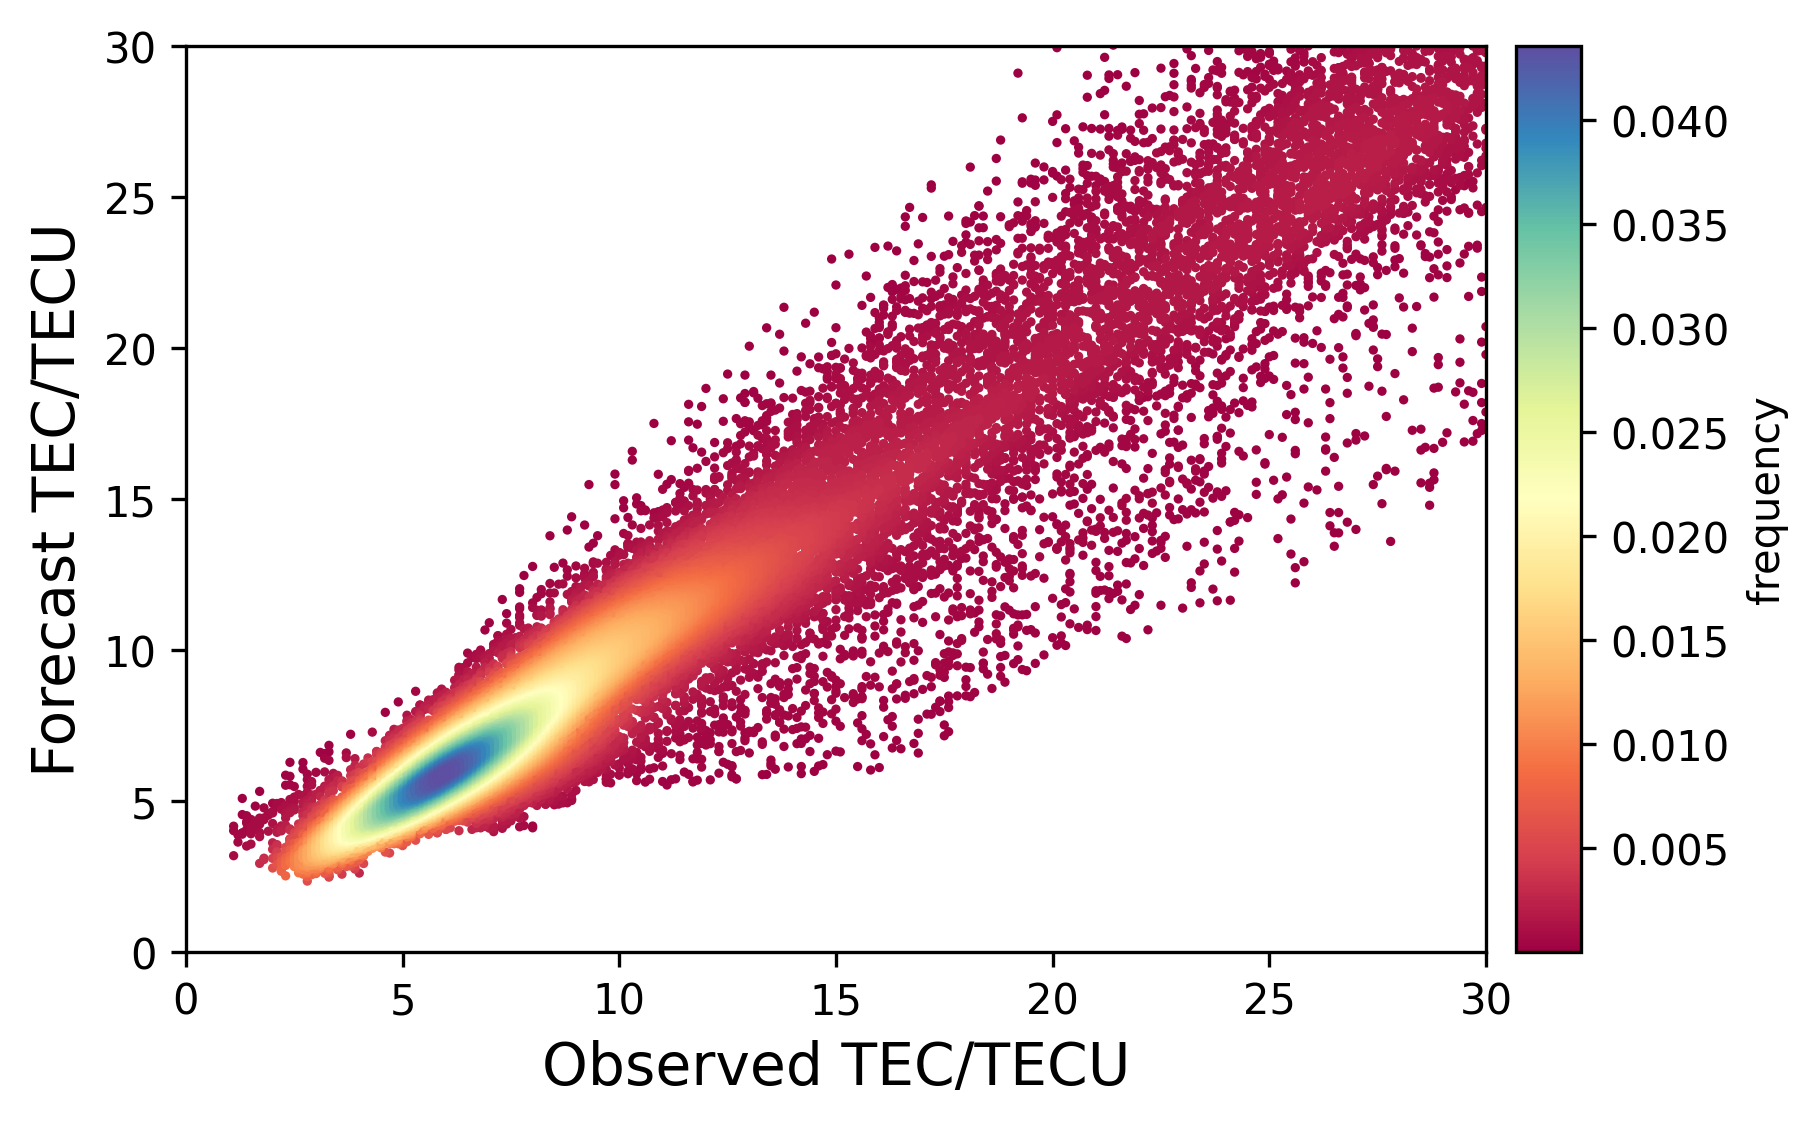

In [113]:
fig, ax = plt.subplots(dpi=300) 
r = np.squeeze(R[:30000])
p = np.squeeze(P[:30000])
xy = np.vstack([r,p])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
r,p,z = r[idx],p[idx],z[idx]
scatter = ax.scatter(r,p,s=5,c=z,marker='o',edgecolors='',cmap='Spectral')
ax.set_xlim(0,30)
ax.set_ylim(0,30)
plt.xlabel('Observed TEC/TECU', fontsize=14)
plt.ylabel('Forecast TEC/TECU', fontsize=14)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(scatter, cax=cax, label='frequency')

# ax.plot(line_x, y, 'k')
# # # plt.text(100, 40, r'$k_a$', fontsize=18)

# ax.text(20,5, 'R:{}\nK:{}'.format(r2, round(reg.coef_[0][0],4)))